In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import os
import torch
import torch.nn as nn
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import torchvision.transforms as transform
import torchvision.models as models
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42);

In [5]:
gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
# !ls /content
# drive	'Pediatric Chest X-ray Pneumonia'   sample_data

In [7]:
# %cd Pediatric Chest X-ray Pneumonia
# /content/Pediatric Chest X-ray Pneumonia

Found 1349 elements for NORMAL
Found 3883 elements for PNEUMONIA
Found 2494 elements for TUBERCULOSIS


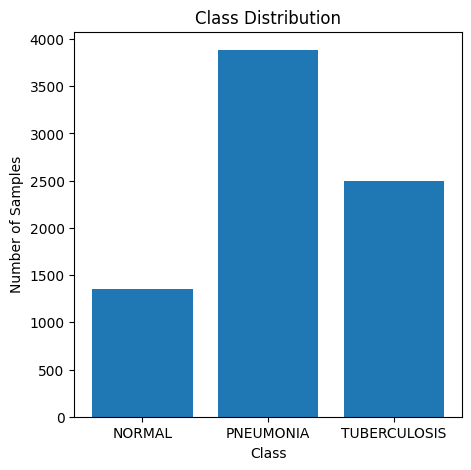

In [8]:
import os
import matplotlib.pyplot as plt

# Define the dataset paths for the 3 categories
normal_folder = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train/NORMAL'
pneumonia_folder = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train/PNEUMONIA'
tuberculosis_folder = '/kaggle/input/majorprojectdeteset/Dataset of Tuberculosis Chest X-rays Images/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays'

# Get the number of samples for each class
n_samples_nr_train = len(os.listdir(normal_folder))
n_samples_pn_train = len(os.listdir(pneumonia_folder))
n_samples_tb_train = len(os.listdir(tuberculosis_folder))

# Define class names and counts
class_names = {0: 'NORMAL', 1: 'PNEUMONIA', 2: 'TUBERCULOSIS'}
class_count = {0: n_samples_nr_train, 1: n_samples_pn_train, 2: n_samples_tb_train}

# Print the class count
print(f'Found {class_count[0]} elements for {class_names[0]}')
print(f'Found {class_count[1]} elements for {class_names[1]}')
print(f'Found {class_count[2]} elements for {class_names[2]}')

# Plot the class distribution
fig, ax = plt.subplots(figsize=(5,5))
ax.bar([class_names[0], class_names[1], class_names[2]], [class_count[0], class_count[1], class_count[2]])

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


In [9]:
# Get the sample count for each class
samples_0 = class_count[0]  # Normal
samples_1 = class_count[1]  # Pneumonia
samples_2 = class_count[2]  # Tuberculosis

# Calculate total samples
tot_samples = samples_0 + samples_1 + samples_2

# Calculate the weight for each class
weight_0 = 1 - samples_0 / tot_samples
weight_1 = 1 - samples_1 / tot_samples
weight_2 = 1 - samples_2 / tot_samples

# Store class weights as a list
class_weights = [weight_0, weight_1, weight_2]

# Convert the list to a Tensor
class_weights = torch.FloatTensor(class_weights)

print("Class weights: ", class_weights)


Class weights:  tensor([0.8254, 0.4974, 0.6772])


In [10]:
# import os
# import shutil

# def delete_all_folders_in_dir(directory):
#     # Iterate over all entries in the directory
#     for entry in os.listdir(directory):
#         path = os.path.join(directory, entry)
#         # Check if it's a directory
#         if os.path.isdir(path):
#             # Delete the directory and its contents
#             shutil.rmtree(path)

# # Example usage
# directory_path = '/kaggle/working/'
# delete_all_folders_in_dir(directory_path)


In [11]:
import os
import shutil
import random

# Function to copy images to the target category folder, and randomly select a few for test
def copy_images_with_random_test(source_folder, target_category_folder, test_category_folder, num_test_images=5):
    # Get all image files in the source folder
    image_files = [file for file in os.listdir(source_folder) if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
    
    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select the first 'num_test_images' images after shuffling for the test set
    selected_test_images = image_files[:num_test_images]

    # Ensure the target category folder and test category folder exist
    os.makedirs(target_category_folder, exist_ok=True)
    os.makedirs(test_category_folder, exist_ok=True)  # Ensure the test category folder exists

    # Copy all images to the target category folder, and test images to the test category folder
    for file in image_files:
        src_file = os.path.join(source_folder, file)
        
        # Skip the images that are selected for the test set
        if file in selected_test_images:
            test_dst_file = os.path.join(test_category_folder, file)
            if not os.path.exists(test_dst_file):
                shutil.copy(src_file, test_dst_file)
                # print(f"Copied to test: {src_file} -> {test_dst_file}")
            continue  # Skip copying to the main category folder for test images

        # Copy to the main Data directory (target category folder) only if it's not a test image
        dst_file = os.path.join(target_category_folder, file)
        if not os.path.exists(dst_file):
            shutil.copy(src_file, dst_file)

# Define the target directory to copy images
target_dir = '/kaggle/working/Data/'  # Replace this with the actual target directory path

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Categories (folders within the target directory)
normal_folder = os.path.join(target_dir, 'Normal')
tuberculosis_folder = os.path.join(target_dir, 'Tuberculosis')
pneumonia_folder = os.path.join(target_dir, 'Pneumonia')

# Define the path for the Test folder outside of the Data folder
test_dir = '/kaggle/working/Test/'  # The Test folder will now be outside the Data directory

# Test category folders inside the Test directory
test_normal_folder = os.path.join(test_dir, 'Normal')
test_tuberculosis_folder = os.path.join(test_dir, 'Tuberculosis')
test_pneumonia_folder = os.path.join(test_dir, 'Pneumonia')

# Ensure the test category folders exist
os.makedirs(test_normal_folder, exist_ok=True)
os.makedirs(test_tuberculosis_folder, exist_ok=True)
os.makedirs(test_pneumonia_folder, exist_ok=True)

# Hardcoded paths for Normal, Pneumonia, and Tuberculosis categories
normal1_folder = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train/NORMAL'  # Replace with the actual path for Normal1
normal2_folder = '/kaggle/input/majorprojectdeteset/Dataset of Tuberculosis Chest X-rays Images/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays'  # Replace with the actual path for Normal2
pneumonia_folder_path = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train/PNEUMONIA'  # Replace with the actual path for Pneumonia images
tuberculosis_folder_path = '/kaggle/input/majorprojectdeteset/Dataset of Tuberculosis Chest X-rays Images/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays'  # Replace with the actual path for Tuberculosis images

# Copy all images to the Data directory and 5 random images to the test folder for each category
copy_images_with_random_test(normal1_folder, normal_folder, test_normal_folder, num_test_images=15)
copy_images_with_random_test(normal2_folder, normal_folder, test_normal_folder, num_test_images=15)
copy_images_with_random_test(tuberculosis_folder_path, tuberculosis_folder, test_tuberculosis_folder, num_test_images=30)
copy_images_with_random_test(pneumonia_folder_path, pneumonia_folder, test_pneumonia_folder, num_test_images=30)

print("Image copying complete with test samples!")


Image copying complete with test samples!


In [12]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# Define the dataset path (make sure this is correct)
dataset_path = '/kaggle/working/Data/'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # For pre-trained ResNet models
])

# Load the dataset using ImageFolder (the folder should be structured as: <dataset_path>/class_name/*)
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transform)

# Split dataset into training and validation (80% training, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_split, val_split = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
batch_size = 64
train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)

# Class index mapping for 3 classes
class_index = {0: 'NORMAL', 1: 'PNEUMONIA', 2: 'TUBERCULOSIS'}

# Check the class distribution and split sizes
print(f"Classes: {class_index}")
print(f"Number of training samples: {len(train_split)}")
print(f"Number of validation samples: {len(val_split)}")

# Optionally, print some examples
for images, labels in train_loader:
    print("Batch image size: ", images.size())
    print("Batch label size: ", labels.size())
    break  # Just view one batch


Classes: {0: 'NORMAL', 1: 'PNEUMONIA', 2: 'TUBERCULOSIS'}
Number of training samples: 6591
Number of validation samples: 1648
Batch image size:  torch.Size([64, 3, 224, 224])
Batch label size:  torch.Size([64])


In [13]:
batch_size = 64

# DataLoader for train and validation subsets
train_loader = torch.utils.data.DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=batch_size, shuffle=True)

# Update class_index for 3 classes
class_index = {0: 'NORMAL', 1: 'PNEUMONIA', 2: 'TUBERCULOSIS'}

# Optionally, print a sample batch to check the sizes
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'Batch image size: {images.size()}')  # Should output torch.Size([64, 3, 224, 224])
print(f'Batch label size: {labels.size()}')  # Should output torch.Size([64])


Batch image size: torch.Size([64, 3, 224, 224])
Batch label size: torch.Size([64])


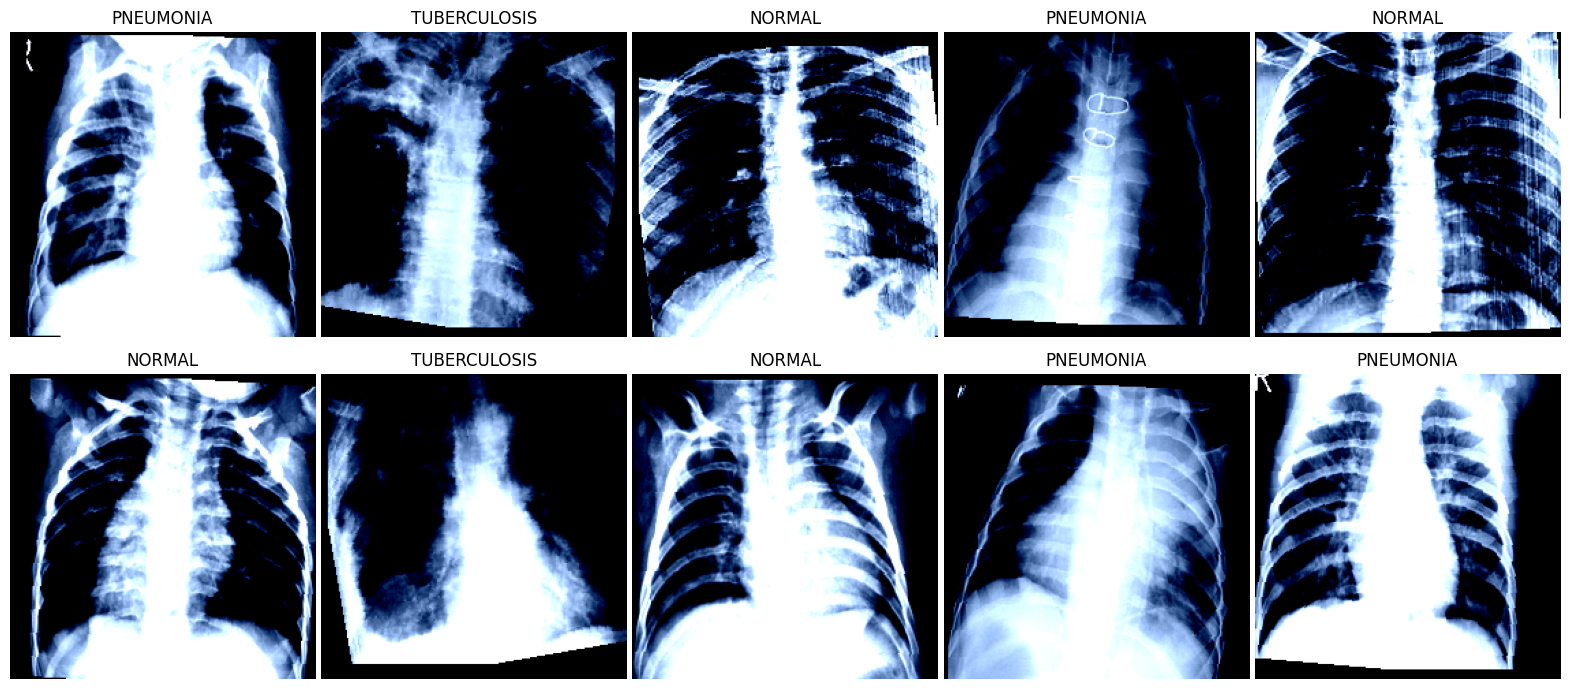

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Set the figure size
n_rows = 2
n_cols = 5

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Loop to plot images
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    # Convert image from Tensor to numpy array and transpose for correct display
    img = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
    plt.imshow(img)
    # Use the class index to display the correct label
    plt.title(class_index[labels[i].item()])
    plt.axis('off')

plt.subplots_adjust(wspace=.02, hspace=-.2)  # Adjust spacing
plt.show()


In [14]:
model = models.resnet50(pretrained=True)
# model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [15]:
in_features = model.fc.in_features
print(in_features)

2048


In [16]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [17]:
initial_num_neurons = model.fc.in_features

num_classes = len(class_index)

classifier = nn.Linear(in_features=in_features, out_features=num_classes)

model.fc = classifier

In [18]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [19]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)
    num_correct    = torch.sum(predictions == labels).item()
    perc_correct   = torch.tensor(num_correct/len(predictions))

    return perc_correct

In [20]:
def training_step(model, loader, loss_function):

    model.train()

    epoch_loss = 0
    epoch_correct = 0

    for images, labels in iter(loader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            output = model(images)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            _, predictions = torch.max(output, dim=1)

        epoch_loss += loss.item()*images.size(0)
        epoch_correct += torch.sum(predictions == labels)

    epoch_loss = epoch_loss / len(loader.dataset)
    accuracy = epoch_correct.double() / len(loader.dataset)
    return epoch_loss, accuracy

In [21]:
def evaluate_model(model, loader, loss_function):

    model.eval()

    epoch_loss = 0
    epoch_correct = 0

    for images, labels in iter(loader):
        images, labels = images.to(device), labels.to(device)

        with torch.set_grad_enabled(False):
            output = model(images)
            loss = loss_function(output, labels)
            _, predictions = torch.max(output, dim=1)

        epoch_loss += loss.item()*images.size(0)
        epoch_correct += torch.sum(predictions == labels)

    epoch_loss = epoch_loss / len(loader.dataset)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

In [22]:
epochs = 10

best_val_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss_savings = []
train_acc_savings  = []
val_loss_savings   = []
val_acc_savings    = []

best_model = copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    train_loss, train_acc = training_step(model, train_loader, loss_function)
    train_loss_savings.append(train_loss)
    train_acc_savings.append(train_acc.item())

    val_loss, val_acc = evaluate_model(model, val_loader, loss_function)
    val_loss_savings.append(val_loss)
    val_acc_savings.append(val_acc.item())

    print(f'Epoch: {epoch+1:02}/{epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

    if val_loss < best_val_loss:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss improved from {best_val_loss:.4f} to {val_loss:.4f}, new model saved')
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
    else:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss did not improve')

    scheduler.step()

Epoch: 01/10 - train_loss: 0.4478 - train_accuracy: 0.8381 - val_loss: 0.2777 - val_accuracy: 0.9193
Epoch: 01/10 - val_loss improved from inf to 0.2777, new model saved
Epoch: 02/10 - train_loss: 0.2376 - train_accuracy: 0.9210 - val_loss: 0.1953 - val_accuracy: 0.9399
Epoch: 02/10 - val_loss improved from 0.2777 to 0.1953, new model saved
Epoch: 03/10 - train_loss: 0.2135 - train_accuracy: 0.9269 - val_loss: 0.1664 - val_accuracy: 0.9448
Epoch: 03/10 - val_loss improved from 0.1953 to 0.1664, new model saved
Epoch: 04/10 - train_loss: 0.1889 - train_accuracy: 0.9337 - val_loss: 0.1954 - val_accuracy: 0.9223
Epoch: 04/10 - val_loss did not improve
Epoch: 05/10 - train_loss: 0.1673 - train_accuracy: 0.9416 - val_loss: 0.1602 - val_accuracy: 0.9448
Epoch: 05/10 - val_loss improved from 0.1664 to 0.1602, new model saved
Epoch: 06/10 - train_loss: 0.1553 - train_accuracy: 0.9493 - val_loss: 0.1599 - val_accuracy: 0.9442
Epoch: 06/10 - val_loss improved from 0.1602 to 0.1599, new model sav

In [23]:
torch.save(best_model,'/kaggle/working/best_model.pth')

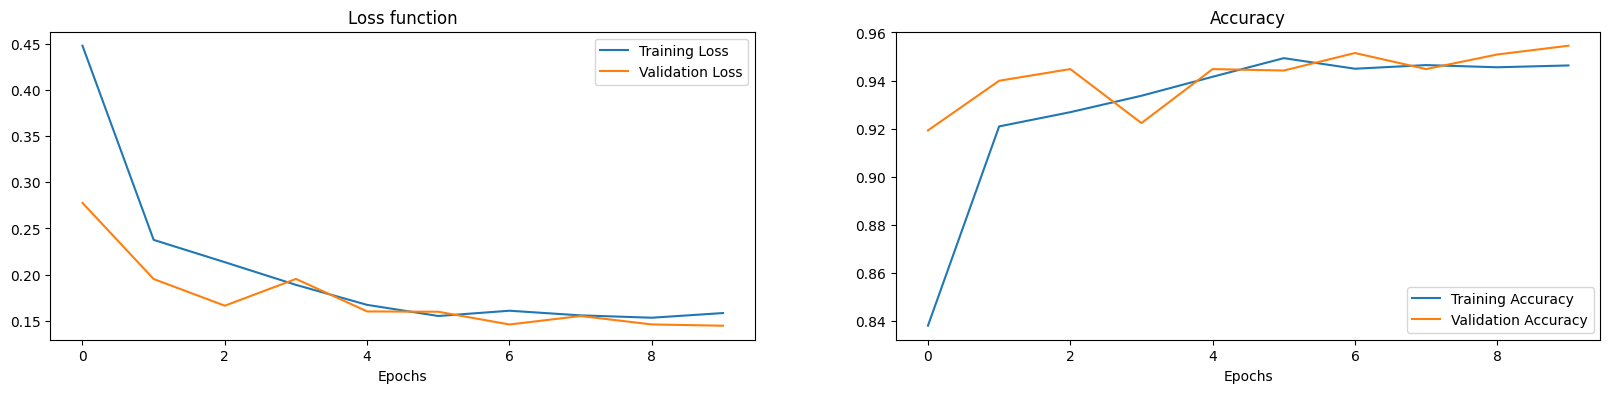

In [24]:
plt.figure(figsize=(20,4));

plt.subplot(1,2,1)
plt.plot(train_loss_savings, label='Training Loss');
plt.plot(val_loss_savings, label='Validation Loss');
plt.title('Loss function');
plt.xlabel('Epochs');
plt.legend();

plt.subplot(1,2,2)
plt.plot(train_acc_savings, label='Training Accuracy');
plt.plot(val_acc_savings, label='Validation Accuracy');
plt.title('Accuracy');
plt.xlabel('Epochs');
plt.legend();

In [25]:
# test_transform = transforms.Compose([
#                      transforms.Resize((256, 256)),
#                      transforms.CenterCrop(224),
#                      transforms.ToTensor()])


test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Ensure normalization is applied the same way
])


test_data = datasets.ImageFolder('/kaggle/working/Test', transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)




In [26]:
def get_probs_and_preds(model, loader):

    model.eval()

    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []

    for images, labels in iter(loader):
        images, labels = images.to(device), labels.to(device)

        with torch.set_grad_enabled(False):
            output = model(images)
            output = F.softmax(output)
            probabilities, predictions = torch.max(output, dim=1)

        images_savings.append(images.cpu())
        labels_savings += labels.tolist()
        probs_savings  += probabilities.tolist()
        preds_savings  += predictions.tolist()

    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

In [27]:
from sklearn.metrics import classification_report

images, labels, probs, preds, accuracy = get_probs_and_preds(model, val_loader)

report = classification_report(labels, preds)

print(f'Accuracy on test: {accuracy:.4f}')
print(report)

Accuracy on test: 0.9478
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       353
           1       0.96      0.96      0.96       779
           2       0.98      0.98      0.98       516

    accuracy                           0.95      1648
   macro avg       0.94      0.94      0.94      1648
weighted avg       0.95      0.95      0.95      1648



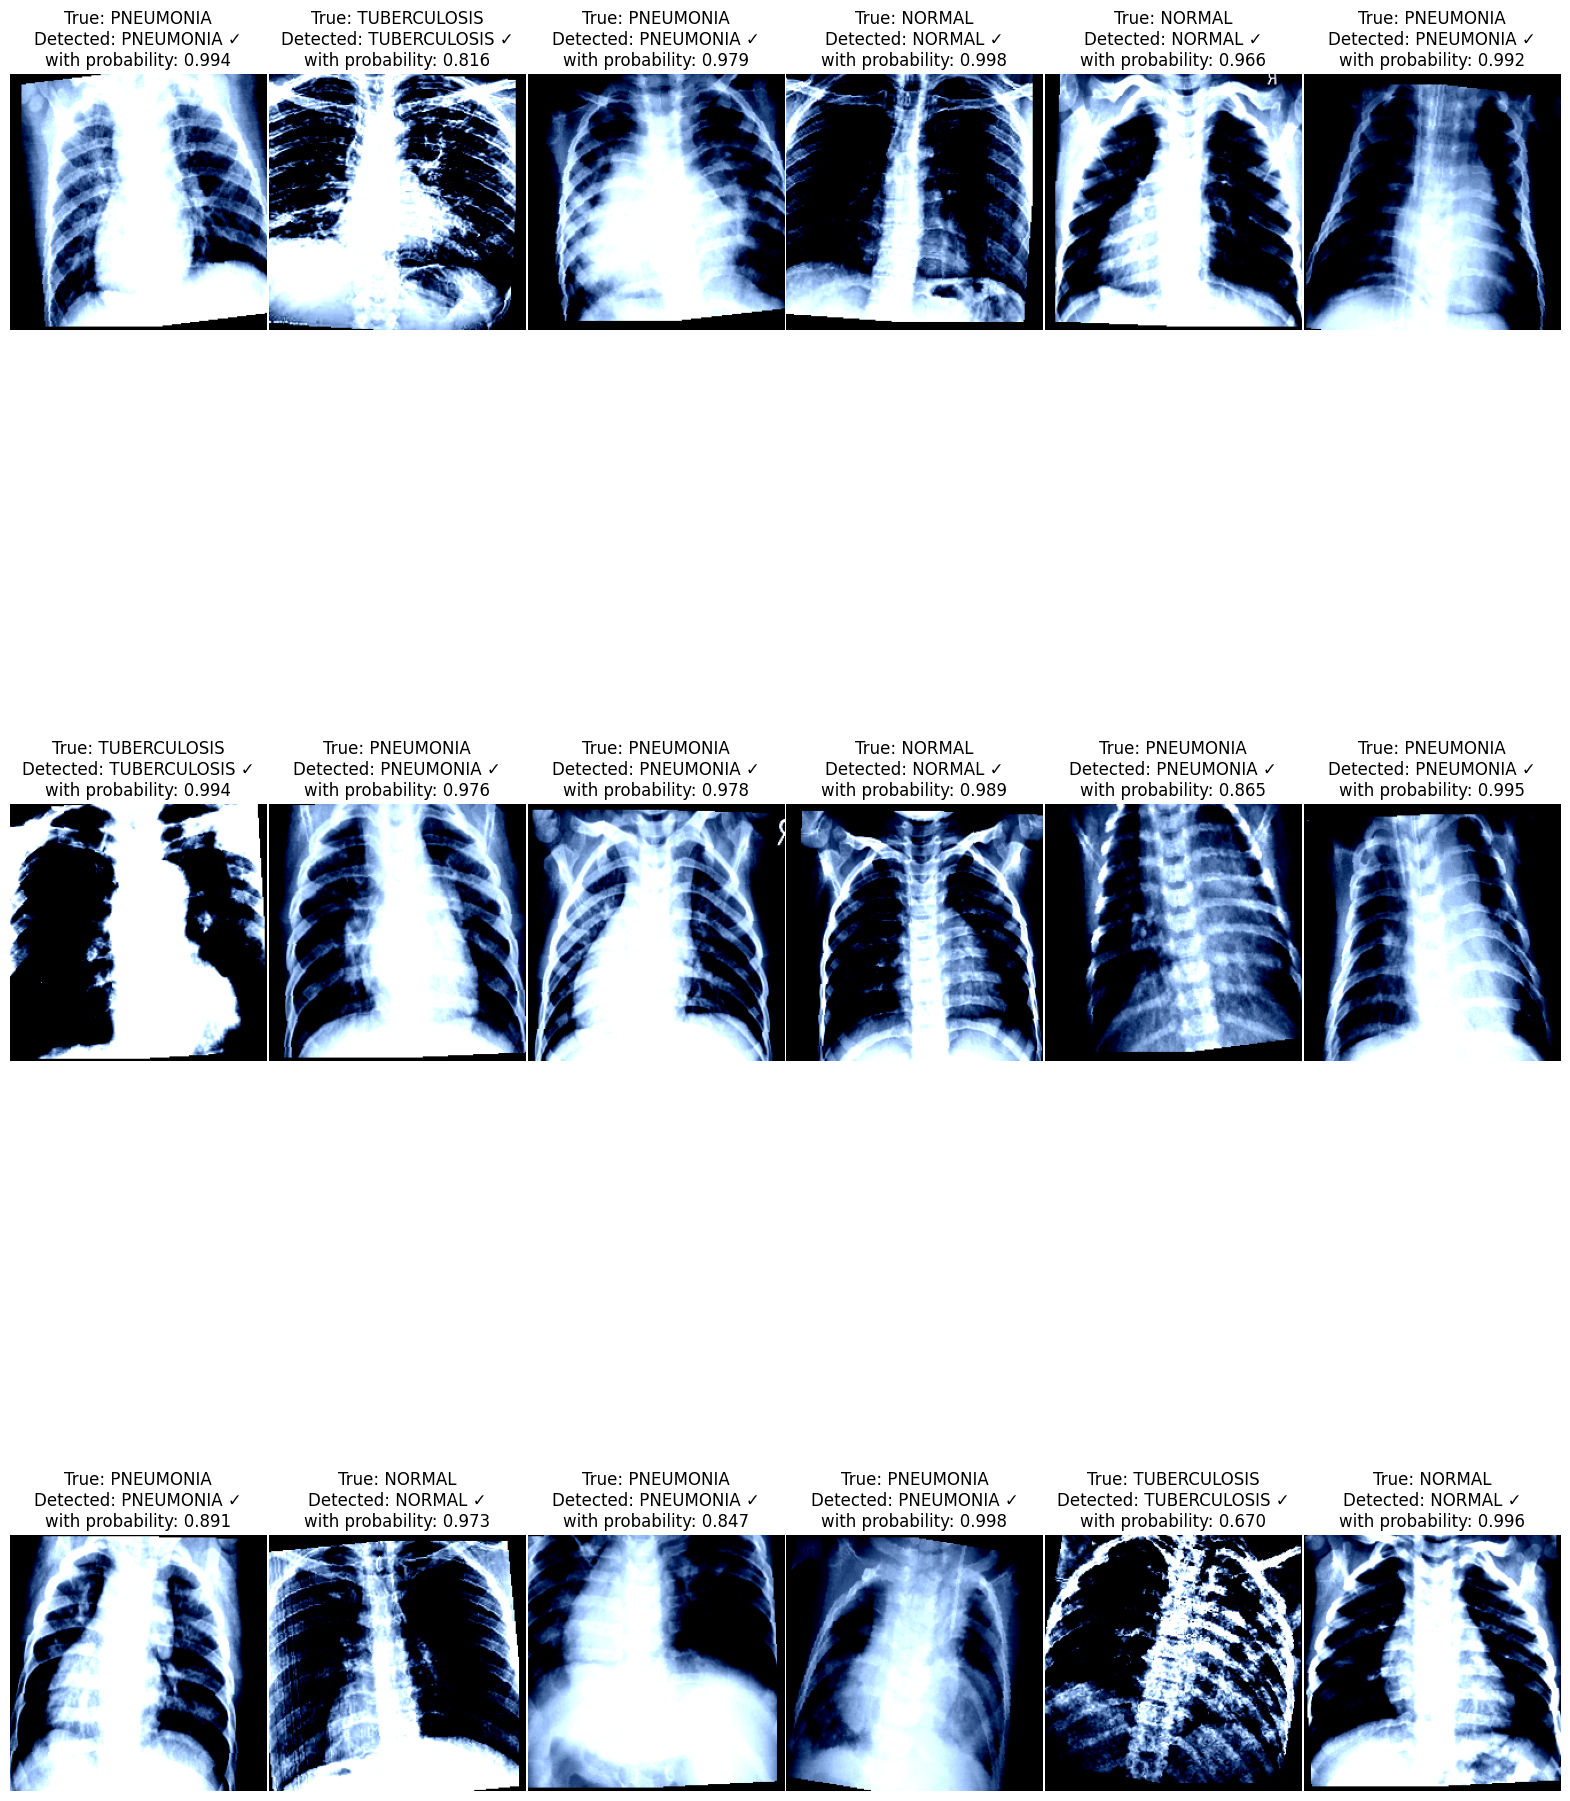

In [28]:
plt.figure(figsize=(20, 26))
n_rows = 3
n_cols = 6

for i in range(n_rows*n_cols):
  text_true = 'True: ' + class_index[labels[i]]
  text_pred = '\nDetected: ' + class_index[preds[i]]
  text_prob = '\nwith probability: ' + str(probs[i])[:5]

  if labels[i] == preds[i]:
      text_correct = ' ✓'
  else:
      text_correct = ' ✗'

  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[0][i].numpy(), (1, 2, 0)))
  plt.title(text_true + text_pred + text_correct + text_prob)
  plt.axis('off')

plt.subplots_adjust(wspace=.01, hspace=.35)

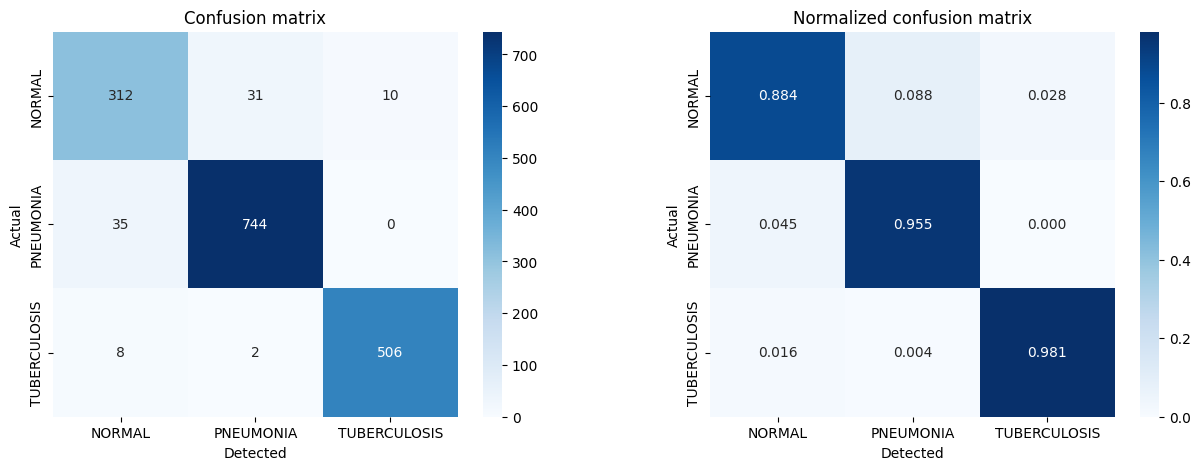

In [29]:
cm = confusion_matrix(labels, preds)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ticklabels = class_index.values()

fig, ax = plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Detected');
plt.ylabel('Actual');

plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Detected');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)